In [100]:
print("ok")

ok


In [174]:
import os
import random
import requests
import warnings
from datetime import datetime
from datetime import datetime, timedelta

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools


# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [102]:
# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [103]:
new_df["time"] = pd.to_datetime(new_df["time"])

In [104]:

df = new_df.drop(columns=['relative_humidity_2m_mean','weather_label', 'Complaint_Count_diff1','year',"month"])


In [105]:
df.head()

,time,temp_max_C,precip_mm,day_of_week,wind_speed_max_m_s,Complaint_Count
0,2022-06-10,41.0,0.1,4,16.6,10
1,2022-06-11,41.0,0.2,5,25.3,12
2,2022-06-12,39.8,0.0,6,16.7,5
3,2022-06-13,40.2,0.0,0,13.3,15
4,2022-06-14,39.2,8.6,1,19.0,16


In [106]:
df['day_of_month'] = df['time'].dt.day
df['day_of_year'] = df['time'].dt.dayofyear

In [107]:
df

,time,temp_max_C,precip_mm,day_of_week,wind_speed_max_m_s,Complaint_Count,day_of_month,day_of_year
0,2022-06-10,41.0,0.1,4,16.6,10,10,161
1,2022-06-11,41.0,0.2,5,25.3,12,11,162
2,2022-06-12,39.8,0.0,6,16.7,5,12,163
3,2022-06-13,40.2,0.0,0,13.3,15,13,164
4,2022-06-14,39.2,8.6,1,19.0,16,14,165
...,...,...,...,...,...,...,...,...
1178,2025-10-15,31.4,0.0,2,6.1,18,15,288
1179,2025-10-16,30.9,0.0,3,8.2,18,16,289
1180,2025-10-17,31.0,0.0,4,7.8,17,17,290
1181,2025-10-18,30.5,0.0,5,6.3,37,18,291


### Convert day-based features into sine–cosine cyclical form

In [108]:
# Day of Week (7 days cycle)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Day of Month (approx 31 days cycle)
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

# Day of Year (365 days cycle)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [109]:
df.head()

,time,temp_max_C,precip_mm,day_of_week,wind_speed_max_m_s,Complaint_Count,day_of_month,day_of_year,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
0,2022-06-10,41.0,0.1,4,16.6,10,10,161,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
1,2022-06-11,41.0,0.2,5,25.3,12,11,162,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2,2022-06-12,39.8,0.0,6,16.7,5,12,163,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
3,2022-06-13,40.2,0.0,0,13.3,15,13,164,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
4,2022-06-14,39.2,8.6,1,19.0,16,14,165,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967


In [110]:
df.drop(['day_of_week', 'day_of_month', 'day_of_year'], axis=1, inplace=True)

In [111]:
df.set_index('time', inplace=True)

In [112]:
df.head()

,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,,,
2022-06-10,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
2022-06-11,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2022-06-12,39.8,0.0,16.7,5,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
2022-06-13,40.2,0.0,13.3,15,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
2022-06-14,39.2,8.6,19.0,16,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967


In [121]:
# Separate features (X) and target (y)
X = df.drop(columns=['Complaint_Count'])
y = df['Complaint_Count']
# Split data into train and test sets (80-20 split)
train_size = int(len(df) * 0.9)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]
# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(f"Training set size: {len(y_train)}")
print(f"Test set size: {len(y_test)}")
print(f"Date range - Train: {df.index[0]} to {df.index[train_size-1]}")
print(f"Date range - Test: {df.index[train_size]} to {df.index[-1]}")

X_train shape: (1064, 9)
X_test shape: (119, 9)
y_train shape: (1064,)
y_test shape: (119,)
Training set size: 1064
Test set size: 119
Date range - Train: 2022-06-10 00:00:00 to 2025-06-17 00:00:00
Date range - Test: 2025-06-18 00:00:00 to 2025-10-19 00:00:00


In [122]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [123]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (1064, 9)
X_test_scaled shape: (119, 9)
y_train_scaled shape: (1064, 1)
y_test_scaled shape: (119, 1)


In [150]:
# CREATE SEQUENCES FOR LSTM
def create_sequences(X, y, lookback=7):
    """Create sequences for LSTM model"""
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)
lookback = 7  # Use previous 5 days to predict next day
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)

print(f"Training sequence shape: {X_train_seq.shape}")
print(f"Test sequence shape: {X_test_seq.shape}")

Training sequence shape: (1057, 7, 9)
Test sequence shape: (112, 7, 9)


In [152]:
X_train_seq[0]

array([[8.33333333e-01, 1.33511348e-03, 3.72483221e-01, 2.77479066e-01,
        0.00000000e+00, 9.49479173e-01, 2.77950623e-01, 6.80858540e-01,
        3.38374997e-02],
       [8.33333333e-01, 2.67022697e-03, 6.64429530e-01, 0.00000000e+00,
        3.56895868e-01, 8.95895998e-01, 1.91873892e-01, 6.72807757e-01,
        3.07933540e-02],
       [7.83333333e-01, 0.00000000e+00, 3.75838926e-01, 9.90311321e-02,
        8.01937736e-01, 8.26104795e-01, 1.18359232e-01, 6.64705766e-01,
        2.78882416e-02],
       [8.00000000e-01, 0.00000000e+00, 2.61744966e-01, 5.00000000e-01,
        1.00000000e+00, 7.42962822e-01, 6.04163420e-02, 6.56554970e-01,
        2.51230235e-02],
       [7.58333333e-01, 1.14819760e-01, 4.53020134e-01, 9.00968868e-01,
        8.01937736e-01, 6.49873924e-01, 2.04174111e-02, 6.48357783e-01,
        2.24985188e-02],
       [6.08333333e-01, 8.01068091e-02, 3.99328859e-01, 1.00000000e+00,
        3.56895868e-01, 5.50649169e-01, 5.55111512e-17, 6.40116635e-01,
        2.0

In [153]:
y_train_seq[0]

array([0.14102564])

In [159]:
X_train_seq.shape[2]

9

In [161]:
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(lookback, X_train_seq.shape[2])),
    Dropout(0.2),
    
    LSTM(units=32, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=16, return_sequences=False),
    Dropout(0.2),
    
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 7, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 7, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,641 (135.32 KB)

 Trainable params: 34,641 (135.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [162]:
# 5. CALLBACKS FOR BETTER TRAINING

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [163]:
# 6. TRAIN THE MODEL

print("\n" + "="*60)
print("TRAINING LSTM MODEL...")
print("="*60)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


TRAINING LSTM MODEL...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0604 - mae: 0.2044 - val_loss: 0.1019 - val_mae: 0.2289 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0332 - mae: 0.1432 - val_loss: 0.0767 - val_mae: 0.1952 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0307 - mae: 0.1370 - val_loss: 0.0677 - val_mae: 0.1948 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mae: 0.1236 - val_loss: 0.0770 - val_mae: 0.2149 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - mae: 0.1236 - val_loss: 0.0682 - val_mae: 0.1973 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - mae: 0.1209 - val_loss: 0.0654 - val_mae: 0.1941 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0260 - mae: 0.1215 - val_loss: 0.0719 - val_mae: 0.2062 - learning_r

In [165]:
# 7. MAKE PREDICTIONS


y_train_pred_scaled = model.predict(X_train_seq)
y_test_pred_scaled = model.predict(X_test_seq)

# Inverse scaling to get actual values
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_train_actual = scaler_y.inverse_transform(y_train_seq)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [167]:
# 8. MODEL EVALUATION

print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Training metrics
train_mse = mean_squared_error(y_train_actual, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, y_train_pred)
train_r2 = r2_score(y_train_actual, y_train_pred)

print("\nTRAINING METRICS:")
print(f"  MSE:  {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")


MODEL EVALUATION

TRAINING METRICS:
  MSE:  197.0809
  RMSE: 14.0386
  MAE:  10.5005
  R²:   0.2222


In [169]:
# Testing metrics
test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)


In [172]:
print("\nTEST METRICS:")
print(f"  MSE:  {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")


TEST METRICS:
  MSE:  557.6862
  RMSE: 23.6154
  MAE:  19.0271
  R²:   -1.2026


In [173]:
# 9. VISUALIZATIONS

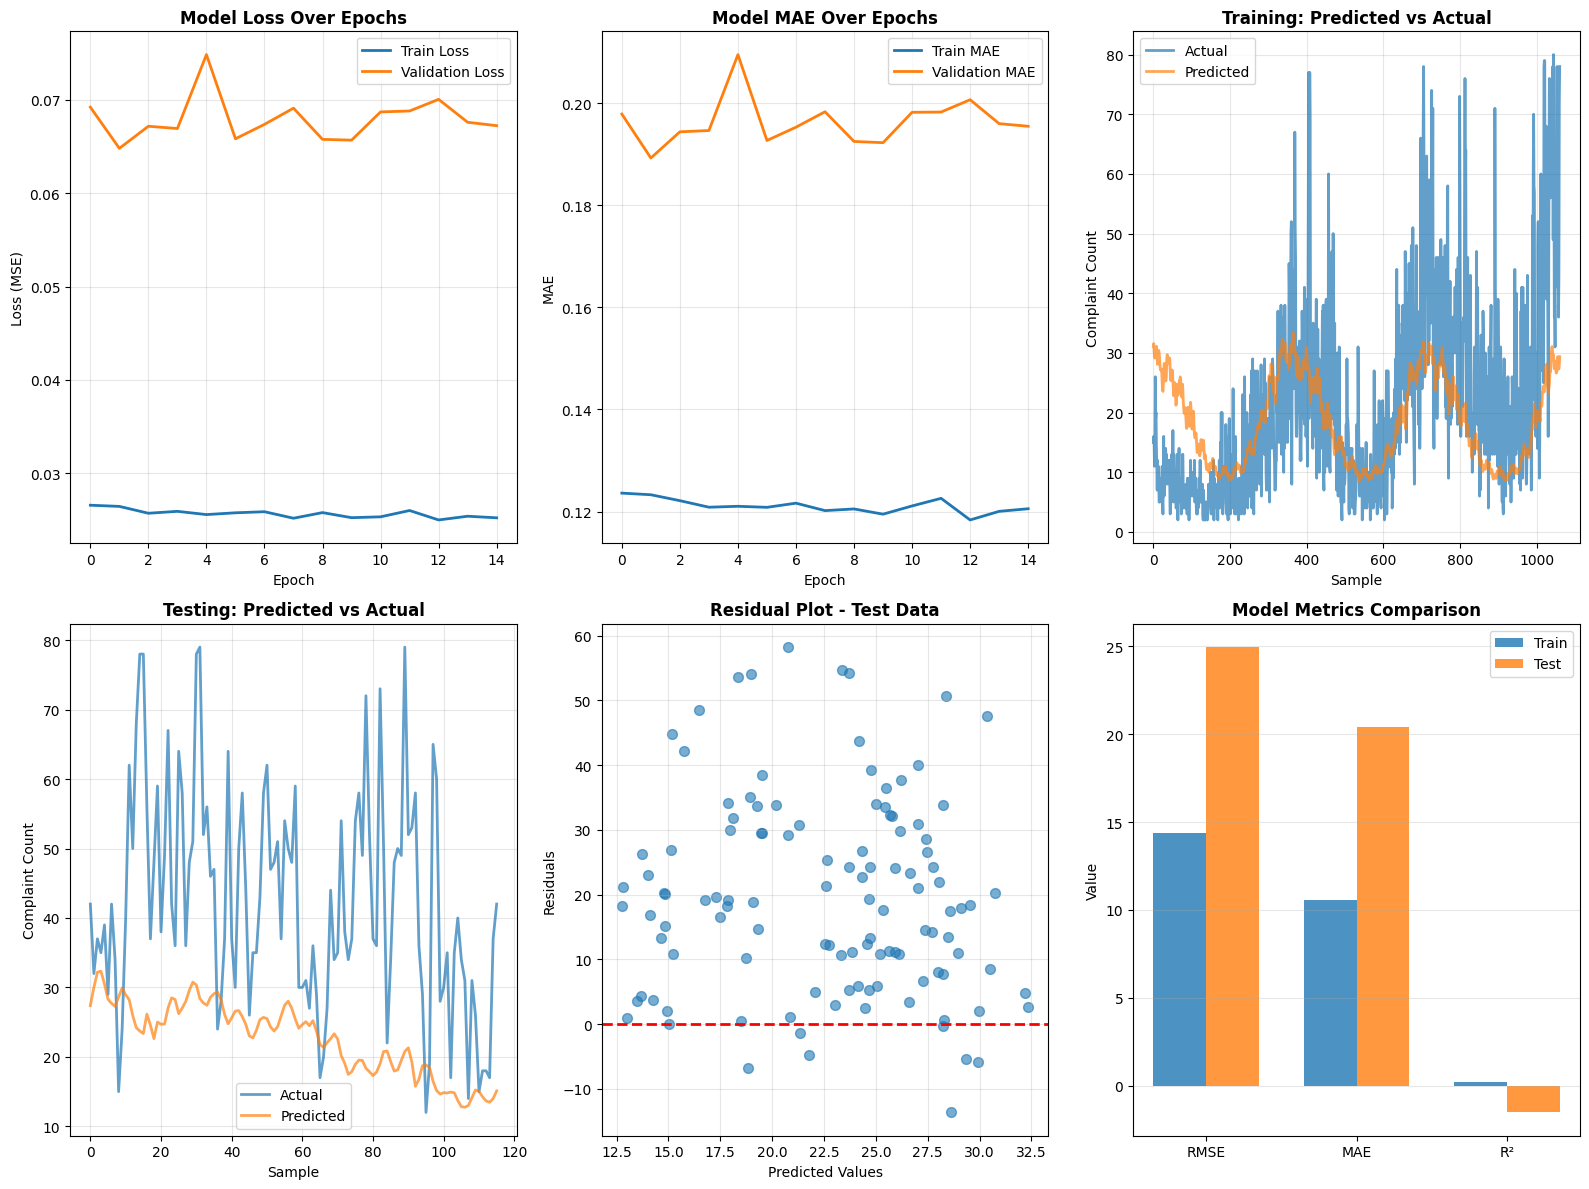

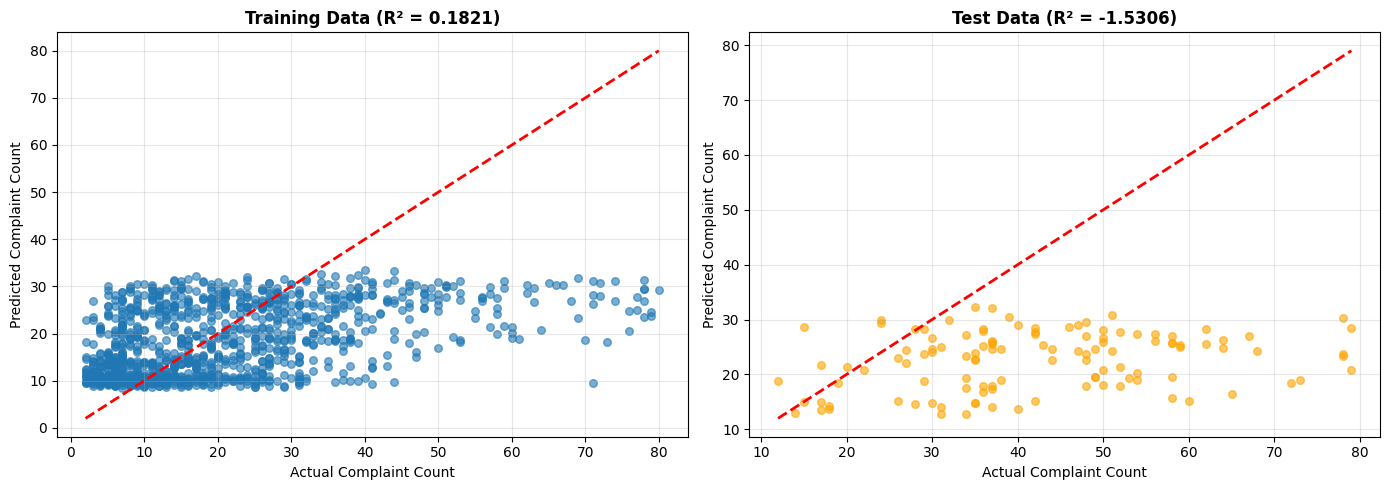


MODEL TRAINING COMPLETE!


In [149]:
fig = plt.figure(figsize=(16, 12))

# 1. Training History - Loss
ax1 = plt.subplot(2, 3, 1)
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Training History - MAE
ax2 = plt.subplot(2, 3, 2)
ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
ax2.set_title('Model MAE Over Epochs', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Predictions vs Actual - Training
ax3 = plt.subplot(2, 3, 3)
ax3.plot(y_train_actual, label='Actual', alpha=0.7, linewidth=2)
ax3.plot(y_train_pred, label='Predicted', alpha=0.7, linewidth=2)
ax3.set_title('Training: Predicted vs Actual', fontsize=12, fontweight='bold')
ax3.set_xlabel('Sample')
ax3.set_ylabel('Complaint Count')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Predictions vs Actual - Testing
ax4 = plt.subplot(2, 3, 4)
ax4.plot(y_test_actual, label='Actual', alpha=0.7, linewidth=2)
ax4.plot(y_test_pred, label='Predicted', alpha=0.7, linewidth=2)
ax4.set_title('Testing: Predicted vs Actual', fontsize=12, fontweight='bold')
ax4.set_xlabel('Sample')
ax4.set_ylabel('Complaint Count')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Residuals - Test Data
ax5 = plt.subplot(2, 3, 5)
residuals = y_test_actual - y_test_pred
ax5.scatter(y_test_pred, residuals, alpha=0.6, s=50)
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_title('Residual Plot - Test Data', fontsize=12, fontweight='bold')
ax5.set_xlabel('Predicted Values')
ax5.set_ylabel('Residuals')
ax5.grid(True, alpha=0.3)

# 6. Metrics Comparison
ax6 = plt.subplot(2, 3, 6)
metrics = ['RMSE', 'MAE', 'R²']
train_vals = [train_rmse, train_mae, train_r2]
test_vals = [test_rmse, test_mae, test_r2]
x = np.arange(len(metrics))
width = 0.35
ax6.bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
ax6.bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
ax6.set_ylabel('Value')
ax6.set_title('Model Metrics Comparison', fontsize=12, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# ============================================================================
# 10. ADDITIONAL VISUALIZATION - Scatter Plot
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train scatter
axes[0].scatter(y_train_actual, y_train_pred, alpha=0.6, s=30)
axes[0].plot([y_train_actual.min(), y_train_actual.max()], 
             [y_train_actual.min(), y_train_actual.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Complaint Count')
axes[0].set_ylabel('Predicted Complaint Count')
axes[0].set_title(f'Training Data (R² = {train_r2:.4f})', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test scatter
axes[1].scatter(y_test_actual, y_test_pred, alpha=0.6, s=30, color='orange')
axes[1].plot([y_test_actual.min(), y_test_actual.max()], 
             [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Complaint Count')
axes[1].set_ylabel('Predicted Complaint Count')
axes[1].set_title(f'Test Data (R² = {test_r2:.4f})', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)